In [43]:
import os,sys
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np 
from scipy.spatial.distance import pdist
import time 
import math
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

In [44]:
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
%run ../lib/load.py

## Loading Data

In [45]:
## change the root to your own path 

#root = sys.path[0]
#train_dir =  os.path.join(root,  '../data/train_set')  
#train_image_dir =  os.path.join(train_dir, 'images')
#train_pt_dir =  os.path.join(train_dir, 'points' )
#train_label_path =  os.path.join(train_dir,  "label.csv")
path = '/Users/zhaoziqin/Desktop/train_set/'
data = load.load_data(path+'label.csv')
points_path = '/Users/zhaoziqin/Desktop/train_set/points/'
X = load.load_points(points_path,data)
y= data['emotion_idx'].to_numpy()

--- 13.693434238433838 seconds ---


## Mat file changes

In [46]:
# read mat file and store coordinates in mat 
m = []
for idx in data['Index']: 
    file = "%04d.mat"%(idx)
    m.append( scipy.io.loadmat( os.path.join( points_path, file )))

mat = [x[[i for i in x.keys() if not i in ['__header__', '__version__', '__globals__']][0]] for x in m]

## Train Test Split

In [47]:
train_x, test_x, train_idx, test_idx = train_test_split(X, y, test_size=0.2, random_state=123)


In [8]:
#train_idx, test_idx = train_test_split(y, test_size=0.2, random_state=123)

In [48]:
train_mat = [ mat[i-1] for i in train_idx ] 
test_mat = [ mat[i-1] for i in test_idx ]

In [49]:
train_labels = data.emotion_idx[train_idx-1]
test_labels = data.emotion_idx[test_idx-1]

In [50]:
train_label_cat = to_categorical(train_labels)
train_label_cat= train_label_cat[:,1:]
test_label_cat = to_categorical(test_labels)
test_label_cat= test_label_cat[:,1:]

In [51]:
train_label_cat

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [52]:
test_label_cat

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

## Feature Extraction

In [53]:
# method 1：  pairwise_dist_cal  
#def pairwise_dist_cal(xy_cord):
    #p_dist =[]
    #for i in range(xy_cord.shape[0]):
        #for j in range(i+1,xy_cord.shape[0]):
               # p_dist.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
               # p_dist.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
    #return p_dist 



#### updated methods with selected fiducial points; this reduce 78 poins to 50  
''' 
feature selection : 1. remove  points P64 - 70 and P72 - 78  
                 2. remove P51,53,55,57,58,60, 61, 63
                 3. calculate midpints between  upper and lower eyebrow lines and replace P20-22,P24-16 with midpoints               
So there is in total 50 points left, which gives 50*49 pairwise distance 
'''

def pairwise_dist_cal_updt(mt):
    t0 = time.time()
    p_dist_updt =np.zeros([len(mt),1225,2])
    n = len(mt)
    for k in range(n):
        xy_cord = mt[k]

        xy_cord_cpy  = xy_cord
        
        #  eye_brow midpoint 
        to_add_brl = (xy_cord_cpy[19:22]+ xy_cord_cpy[23:26])/2
        to_add_brr = (xy_cord_cpy[27:30]+ xy_cord_cpy[31:34])/2

        # index to remove 
        rm_idx = np.append(np.arange(63,70), np.arange(71,78))
        rm_idx = np.append(rm_idx,np.arange(50,57,2) )
        rm_idx = np.append(rm_idx, [57,59,60,62])
        rm_idx = np.append(rm_idx, np.arange(19,22))
        rm_idx = np.append(rm_idx, np.arange(23,26))
        rm_idx = np.append(rm_idx, np.arange(27,30))
        rm_idx = np.append(rm_idx, np.arange(31,34))
        xy_cord = np.delete(xy_cord, rm_idx, axis = 0) 
        xy_cord = np.concatenate((xy_cord,to_add_brl,to_add_brr))
        

        dist_h = [] 
        dist_v = []
        for i in range(xy_cord.shape[0]):
            for j in range(i+1,xy_cord.shape[0]):
                dist_h.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
                dist_v.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
        p_dist_updt[k,:,0]= dist_h
        p_dist_updt[k,:,1]= dist_v
    

    print("feature constructions takes %s seconds" % (time.time() - t0))
    return p_dist_updt.reshape([n,2450])

In [54]:
print("training: ")
train_data = pairwise_dist_cal_updt(train_mat[0:])

training: 
feature constructions takes 17.47185206413269 seconds


In [55]:
print("testing: ")
test_data = pairwise_dist_cal_updt(test_mat[0:])

testing: 
feature constructions takes 4.426961898803711 seconds


### LDA

In [17]:
train_labels_lda = [ x  - 1 for x in train_labels ] 
test_labels_lda = [ x  - 1 for x in test_labels ]

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
X_train_lda = lda.fit_transform(train_data, train_labels_lda)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:402: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]


In [19]:
X_test_lda = lda.transform(test_data)

In [20]:
start_time = time.time()

lda_test_pred = lda.predict(test_data)

In [21]:
lda_accuracy = lda.score(test_data, test_labels_lda)
print("Accuracy of the LDA mode: %.4f" % (lda_accuracy))

Accuracy of the LDA mode: 1.0000


### XGB

In [21]:
from xgboost.sklearn import XGBClassifier

In [22]:
train_labels_xgb = [ x  - 1 for x in train_labels ] 
test_labels_xgb = [ x  - 1 for x in test_labels ]

In [23]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators= 200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',  # for multi-labels classification 
 num_class = 22, 
 scale_pos_weight=1,
 seed=123)
start_time=time.time()
xgb.fit(train_data, train_labels_xgb ,eval_metric='auc')
print("training  model takes %s seconds" % round((time.time() - start_time),3))


training  model takes 804.773 seconds


In [24]:
start_time = time.time()
pred_xgb = xgb.predict(test_data)
print("testing model takes %s seconds" % round((time.time() - start_time),3))


testing model takes 0.418 seconds


In [25]:
acc_xgb = accuracy_score(pred_xgb,test_labels_xgb )
print("Test accuracy is %s percent" %(acc_xgb*100))

Test accuracy is 49.6 percent


### XGBoost with CV

In [37]:
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(objective='multi:softprob',seed=36)
parameters = {
   'max_depth': range (1, 5, 1),
   'n_estimators': range(1, 200, 20),
   'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
gscv1 = GridSearchCV(estimator = estimator , 
                        param_grid = parameters, 
                        scoring ='accuracy',
                        cv = 5,
                        n_jobs = -1)
gscv1.fit(train_data, train_labels_xgb)

In [ ]:

# accuracy score
print('Best score for data:', gscv1.best_score_) 

# Find the best parameters for the model by using grid search
print('Best Max Depth:',gscv1.best_estimator_.max_depth) 
print('Best N.estimators:',gscv1.best_estimator_.n_estimators)
print('Best Learning Rate:',gscv1.best_estimator_.learning_rate)

### CNN 

In [31]:
#set predictors
from keras.utils import to_categorical
Y = to_categorical(y)
Y = Y[:,1:]

In [32]:
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)

train_x, test_x, train_idx, test_idx = train_test_split(X, Y, test_size=0.2, random_state=123)


In [24]:
#train_labels_cnn = [ x  - 1 for x in train_labels ] 
#test_labels_cnn = [ x  - 1 for x in test_labels ]

# train_labels_cnn = [ x  for x in train_labels ] 
# test_labels_cnn = [ x  for x in test_labels ]

In [25]:
# train_label_cat = to_categorical(train_labels_cnn)
# train_label_cat= train_label_cat[:,1:]
# test_label_cat = to_categorical(test_labels_cnn)
# test_label_cat= test_label_cat[:,1:]

In [33]:
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=6))(x) 
model = Model(input_layer,output_layer)


In [35]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_nn = model.fit(train_x,train_idx,epochs=200)
print("training  model takes %s seconds" % round((time.time() - start_time),3))


Epoch 1/200
2000/2000 [==============================] - 7s 4ms/step - loss: 3.0523 - accuracy: 0.0850
Epoch 2/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.6775 - accuracy: 0.1770
Epoch 3/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.3641 - accuracy: 0.2475
Epoch 4/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.2165 - accuracy: 0.2710
Epoch 5/200
2000/2000 [==============================] - 4s 2ms/step - loss: 2.0055 - accuracy: 0.3355
Epoch 6/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.9002 - accuracy: 0.3665
Epoch 7/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.8323 - accuracy: 0.3785
Epoch 8/200
2000/2000 [==============================] - 4s 2ms/step - loss: 1.7076 - accuracy: 0.4295
Epoch 9/200
2000/2000 [==============================] - 5s 2ms/step - loss: 1.6688 - accuracy: 0.4325
Epoch 10/200
2000/2000 [==============================] - 4s 2ms/step - l

2000/2000 [==============================] - 3s 2ms/step - loss: 0.4629 - accuracy: 0.8410
Epoch 80/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4860 - accuracy: 0.8320
Epoch 81/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4826 - accuracy: 0.8340
Epoch 82/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4562 - accuracy: 0.8490
Epoch 83/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4883 - accuracy: 0.8275
Epoch 84/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4560 - accuracy: 0.8400
Epoch 85/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4655 - accuracy: 0.8470
Epoch 86/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4636 - accuracy: 0.8450
Epoch 87/200
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4211 - accuracy: 0.8590
Epoch 88/200
2000/2000 [==============================] - 3s 2ms/step - loss:

2000/2000 [==============================] - 4s 2ms/step - loss: 0.2203 - accuracy: 0.9245
Epoch 158/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2113 - accuracy: 0.9325
Epoch 159/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2288 - accuracy: 0.9300
Epoch 160/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2024 - accuracy: 0.9325
Epoch 161/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2316 - accuracy: 0.9275
Epoch 162/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2080 - accuracy: 0.9315
Epoch 163/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1843 - accuracy: 0.9435
Epoch 164/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2203 - accuracy: 0.9235
Epoch 165/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2120 - accuracy: 0.9350
Epoch 166/200
2000/2000 [==============================] - 4s 2ms/ste

Text(0.5, 1.0, 'Accuracy Curves')

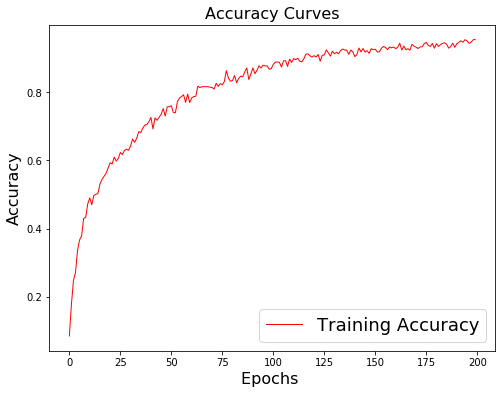

In [37]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [41]:
start = time.time()
pred = model.predict(test_x)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(test_idx, axis=-1)
accuracy = accuracy_score(pred_list,tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % round((time.time() - start),3))



Test accuracy is 56.6 percent
testing model takes 0.288 seconds


In [42]:
NN_pred = model.predict(test_x)

### Multiple Iterations test

In [56]:
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=6))(x) 
model = Model(input_layer,output_layer)

In [57]:
from keras.optimizers import Adam
start_time = time.time()

model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_nn = model.fit(train_x, train_label_cat,epochs=200)
print("training  model takes %s seconds" % round((time.time() - start_time),3))


ValueError: Error when checking target: expected dense_18 to have shape (22,) but got array with shape (1,)

Text(0.5, 1.0, 'Accuracy Curves')

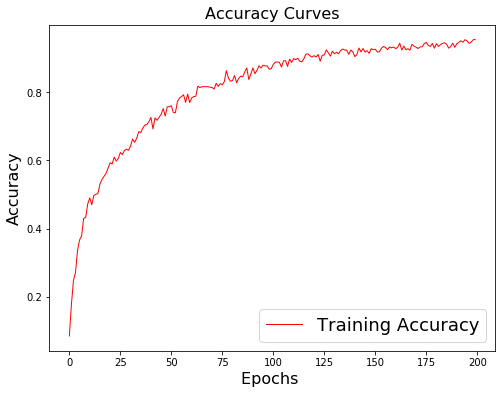

In [36]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [48]:
start = time.time()
pred = model.predict(test_x)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)
accuracy = accuracy_score(pred_list, tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % round((time.time() - start),3))


Test accuracy is 56.2 percent
testing model takes 0.206 seconds
